# Stellar Luminosity Modeling  
## Polynomial Regression with Interaction Terms

In this notebook we extend the linear regression model to capture nonlinear
and interaction effects between stellar mass and temperature.

We explicitly define the hypothesis function, loss function, and optimization
algorithm using NumPy, without relying on machine-learning libraries.

## Step 1: Import Required Libraries

We need NumPy for numerical computations and Matplotlib for visualization.

In [49]:
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Load the Dataset

We define three arrays containing observational data:
- **M**: stellar mass in solar masses (M⊙)
- **T**: effective temperature in Kelvin (K)
- **L**: luminosity in solar luminosities (L⊙)

These 10 stars represent a diverse sample across the mass-temperature-luminosity space.

In [50]:
# Dataset
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])
np.set_printoptions(precision=4, suppress=True)

## Step 3: Visualize the Dataset

We create a scatter plot showing the relationship between stellar mass and luminosity.
Temperature is encoded as color to reveal how it correlates with the other variables.

This visualization helps us understand the underlying data patterns before building the model.

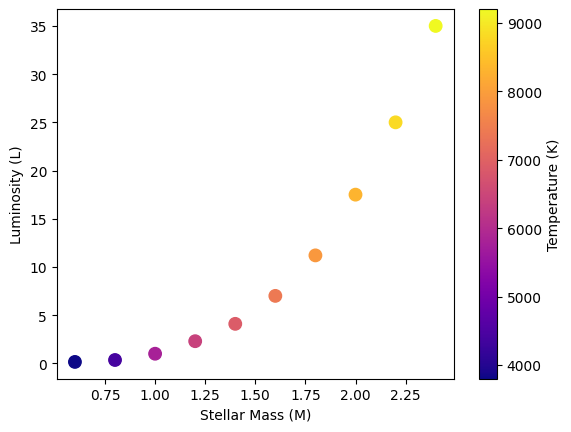

In [51]:
plt.scatter(M, L, c=T, cmap='plasma', s=80)
plt.xlabel("Stellar Mass (M)")
plt.ylabel("Luminosity (L)")
plt.colorbar(label="Temperature (K)")
plt.show()

## Step 4: Feature Engineering - Create the Design Matrix

To capture nonlinear and interaction effects, we construct a design matrix with polynomial and interaction terms:

$$X = [M, \quad T, \quad M^2, \quad M \cdot T]$$

- **Column 1 (M)**: Linear mass term
- **Column 2 (T)**: Linear temperature term
- **Column 3 (M²)**: Quadratic mass term (captures nonlinear mass effects)
- **Column 4 (M·T)**: Interaction term (captures combined effects of mass and temperature)

This transformation allows us to fit a linear model in the expanded feature space.

In [52]:
X = np.column_stack([
    M,
    T,
    M**2,
    M * T
])

N, d = X.shape

## Step 5: Define the Hypothesis Function and Loss Function

**Hypothesis function** (linear predictor over engineered features):

$$\hat{L} = X \cdot w + b$$

where:
- **w** is a vector of 4 weights (one per feature)
- **b** is the bias term

**Loss function** (Mean Squared Error):

$$J(w,b) = \frac{1}{2N} \sum_{i=1}^{N} (\hat{L}_i - L_i)^2$$

The factor 1/2 simplifies gradient calculations without affecting the optimal solution.

In [53]:
def predict(X, w, b):
    return X @ w + b

def cost(X, L, w, b):
    N = len(L)
    return (1 / (2 * N)) * np.sum((predict(X, w, b) - L) ** 2)

## Step 6: Compute Gradient Vectors

We compute the partial derivatives of the loss function with respect to weights and bias:

$$\frac{\partial J}{\partial w} = \frac{1}{N} X^T (\hat{L} - L)$$

$$\frac{\partial J}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} (\hat{L}_i - L_i)$$

These gradients tell us the direction of steepest increase in loss. In gradient descent, we move in the opposite direction.

In [54]:
def gradients(X, L, w, b):
    N = len(L)
    error = predict(X, w, b) - L
    dw = (1 / N) * (X.T @ error)
    db = (1 / N) * np.sum(error)
    return dw, db

## Step 7: Implement Gradient Descent Optimization

We use gradient descent to iteratively minimize the loss function:

**Update rule:**
$$w \leftarrow w - \text{lr} \cdot \frac{\partial J}{\partial w}$$
$$b \leftarrow b - \text{lr} \cdot \frac{\partial J}{\partial b}$$

where **lr** is the learning rate (controls step size).

This algorithm will:
1. Initialize weights and bias to zero
2. Compute gradients
3. Update parameters in the direction of steepest descent
4. Repeat until convergence

In [55]:
def gradient_descent(X, L, lr=1e-8, iterations=5000):
    w = np.zeros(X.shape[1])
    b = 0.0
    losses = []

    for _ in range(iterations):
        dw, db = gradients(X, L, w, b)
        w -= lr * dw
        b -= lr * db
        losses.append(cost(X, L, w, b))

    return w, b, losses

## Step 8: Train the Full Model (M3)

We now train the complete model with all 4 features: [M, T, M², M·T]

Using:
- **Learning rate**: 1e-10 (very small for numerical stability)
- **Iterations**: 5000 (sufficient for convergence)

This produces optimized weights **w** and bias **b** that minimize MSE on the training data.

In [56]:
w_full, b_full, _ = gradient_descent(X, L, lr=1e-10, iterations=5000)

## Step 9: Prepare Analysis of Interaction Term Sensitivity

We will analyze how the cost function changes when we vary the interaction weight (M·T coefficient) around its optimal value.

First, we compute:
- **MT_mean**: Average value of the M·T term in our dataset
- **delta_effect**: A range of 200 perturbations to apply to the interaction weight

In [57]:
MT_mean = np.mean(X[:, -1])
delta_effect = np.linspace(-5, 5, 200)

## Step 10: Analyze Cost Sensitivity to Interaction Weight

For each perturbation **δ** in the interaction weight, we:
1. Create a modified weight vector with the perturbed interaction coefficient
2. Compute the resulting cost
3. Plot cost vs perturbation to visualize the sensitivity

This shows how critical the interaction term is for minimizing error.

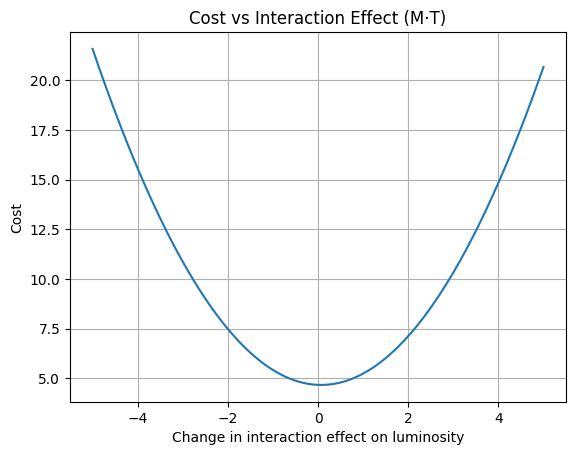

In [58]:
costs = []
for delta in delta_effect:
    w_temp = w_full.copy()
    w_temp[-1] = w_full[-1] + delta / MT_mean
    costs.append(cost(X, L, w_temp, b_full))

plt.plot(delta_effect, costs)
plt.xlabel("Change in interaction effect on luminosity")
plt.ylabel("Cost")
plt.title("Cost vs Interaction Effect (M·T)")
plt.grid(True)
plt.show()

## Step 11: Feature Selection Experiment - Compare Three Models

We compare three polynomial models of increasing complexity:

| Model | Features | Description |
|-------|----------|-------------|
| **M1** | [M, T] | Linear baseline |
| **M2** | [M, T, M²] | Adds quadratic mass term |
| **M3** | [M, T, M², M·T] | Adds interaction term |

For each model:
1. Normalize features for stable convergence
2. Train using gradient descent
3. Plot predicted vs actual luminosity
4. Compare final loss values

We expect M3 to fit best, demonstrating the importance of the interaction effect.

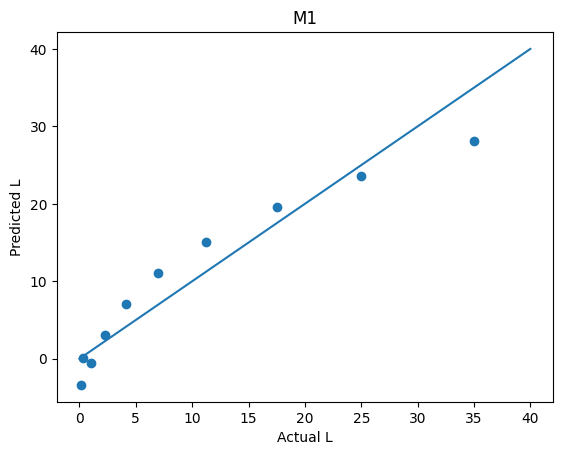

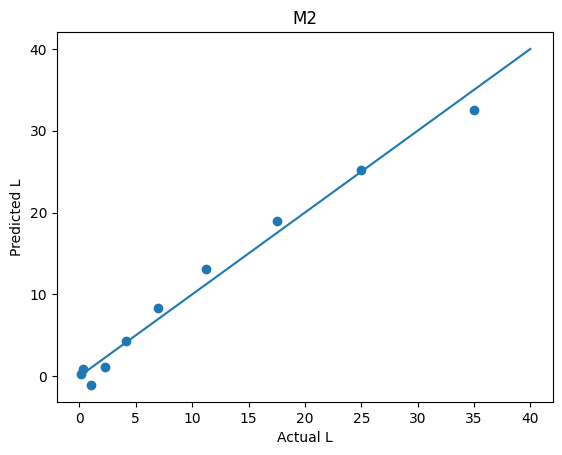

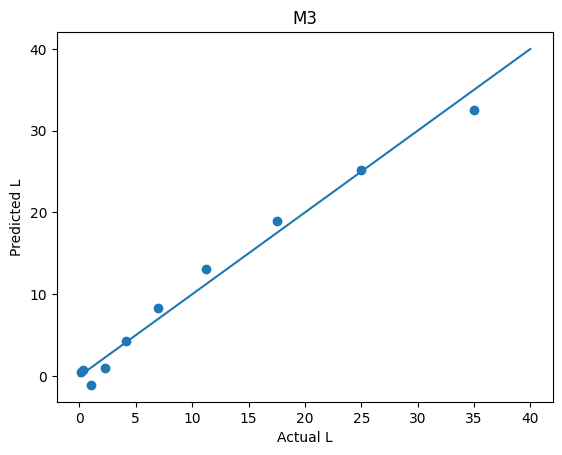

In [59]:
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

models = {
    "M1": np.column_stack([M, T]),
    "M2": np.column_stack([M, T, M**2]),
    "M3": np.column_stack([M, T, M**2, M*T])
}

results = {}

for name, X_model in models.items():
    Xn = normalize(X_model)

    w, b, losses = gradient_descent(Xn, L, lr=1e-2, iterations=5000)

    results[name] = (w, b, losses[-1])

    plt.scatter(L, predict(Xn, w, b))
    plt.plot([0, 40], [0, 40])
    plt.xlabel("Actual L")
    plt.ylabel("Predicted L")
    plt.title(name)
    plt.show()

## Step 12: Detailed Cost Analysis - Interaction Coefficient Sensitivity

We perform a detailed sensitivity analysis of the interaction weight.

**Procedure:**
1. Train the full model again
2. Fix all weights except the M·T coefficient
3. Vary the M·T weight in a narrow range around the optimal value
4. Plot the resulting cost surface

This demonstrates how small deviations from the optimal interaction weight significantly increase error.

Final weights: [-0.     -0.0018  0.      0.0021]
Final bias: -4.461996606087817e-07


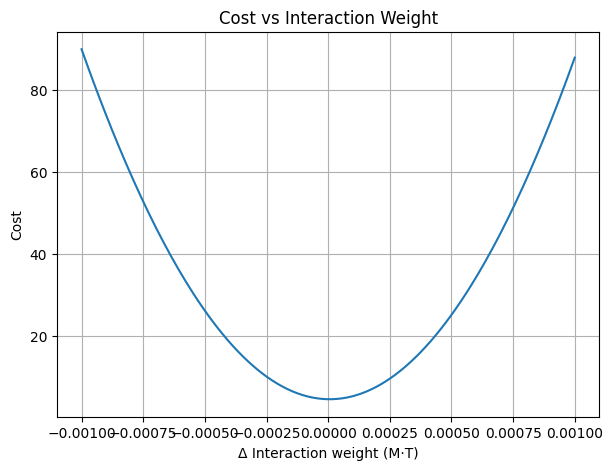

Minimum cost: 4.660141181164543
Maximum cost: 89.88099852242733


In [60]:
w_full, b_full, _ = gradient_descent(X, L, lr=1e-10, iterations=5000)

print("Final weights:", w_full)
print("Final bias:", b_full)

interaction_idx = -1  

w_center = w_full[interaction_idx]

w_range = np.linspace(
    w_center - 1e-3,
    w_center + 1e-3,
    200
)

costs = []

for w_mt in w_range:
    w_temp = w_full.copy()
    w_temp[interaction_idx] = w_mt
    costs.append(cost(X, L, w_temp, b_full))

costs = np.array(costs)

plt.figure(figsize=(7, 5))
plt.plot(w_range - w_center, costs)
plt.xlabel("Δ Interaction weight (M·T)")
plt.ylabel("Cost")
plt.title("Cost vs Interaction Weight")
plt.grid(True)
plt.show()

print("Minimum cost:", costs.min())
print("Maximum cost:", costs.max())

## Step 13: Make Inference on a New Star

We now use the trained model to predict the luminosity of a new star with:
- **Mass**: M = 1.3 M⊙
- **Temperature**: T = 6600 K

**Procedure:**
1. Construct the feature vector: [M, T, M², M·T]
2. Apply the learned transformation: L̂ = X_new · w + b
3. Obtain the predicted luminosity

This demonstrates how the model generalizes to unseen data.

In [61]:
M_new = 1.3
T_new = 6600

X_new = np.array([M_new, T_new, M_new**2, M_new * T_new])

L_pred = float(X_new @ w_full + b_full)

## Step 14: Visualize Predictions vs Actual Values

We create a plot comparing predicted luminosity to actual luminosity for all training data, plus our new star.

**Interpretation:**
- Points near the diagonal line indicate accurate predictions
- Red point shows where the new star's prediction falls
- Deviations from the diagonal indicate systematic prediction errors

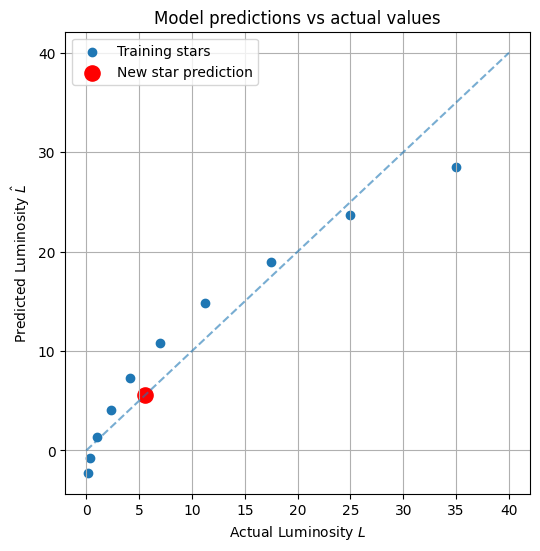

In [62]:
L_train_pred = predict(X, w_full, b_full)

plt.figure(figsize=(6, 6))
plt.scatter(L, L_train_pred, label="Training stars")
plt.scatter(L_pred, L_pred, color="red", s=120, label="New star prediction")

plt.plot([0, 40], [0, 40], linestyle="--", alpha=0.6)

plt.xlabel("Actual Luminosity $L$")
plt.ylabel("Predicted Luminosity $\\hat{L}$")
plt.title("Model predictions vs actual values")
plt.legend()
plt.grid(True)
plt.show()

## Step 15: Visualize Inference in Data Space

We place the new star prediction in the original mass-luminosity-temperature space.

**Plot details:**
- Blue scatter points: observed stars (color indicates temperature)
- Red X marker: predicted star (same mass as input, predicted luminosity)

This allows us to verify if the prediction is physically plausible (lies in the expected region of the data).

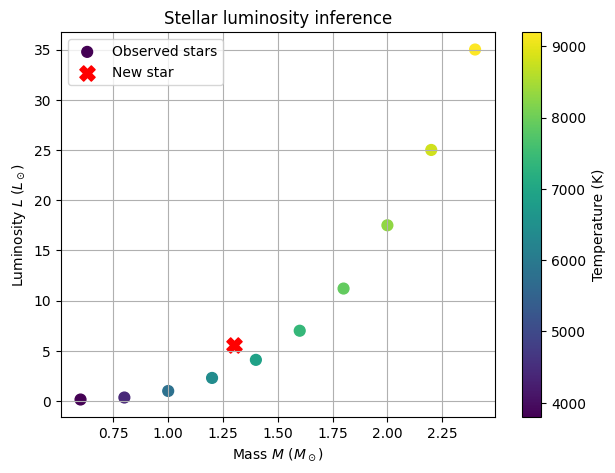

In [63]:
plt.figure(figsize=(7, 5))

sc = plt.scatter(
    M, L,
    c=T,
    cmap="viridis",
    s=60,
    label="Observed stars"
)

plt.scatter(
    M_new, L_pred,
    color="red",
    s=120,
    marker="X",
    label="New star"
)

plt.colorbar(sc, label="Temperature (K)")
plt.xlabel("Mass $M$ ($M_\\odot$)")
plt.ylabel("Luminosity $L$ ($L_\\odot$)")
plt.title("Stellar luminosity inference")
plt.legend()
plt.grid(True)
plt.show()

## Step 16: Print Final Prediction

We output the predicted luminosity for the new star with 3 decimal precision in units of solar luminosities.

In [64]:
print(f"Predicted luminosity for M = {M_new}, T = {T_new} K:")
print(f"L_pred = {L_pred:.3f} L_sun")

Predicted luminosity for M = 1.3, T = 6600 K:
L_pred = 5.590 L_sun


## Conceptual Questions

### 1. Why does polynomial feature engineering improve the model?

Linear regression with only first-order terms assumes a strictly linear relationship between the input features and the target variable. However, stellar luminosity does not increase linearly with mass or temperature. By introducing polynomial and interaction terms (such as ( M^2 ) and ( M \cdot T )), the model gains the capacity to represent nonlinear growth and coupled physical effects. This significantly improves predictive accuracy while still preserving model interpretability.

---

### 2. What is the role of the interaction term ( M \cdot T )?

The interaction term captures how the effect of stellar mass on luminosity depends on temperature (and vice versa). In astrophysical terms, mass and temperature are not independent properties: higher-mass stars tend to have higher core temperatures, which strongly influences energy production. The interaction term allows the model to account for this coupled behavior, leading to a lower overall prediction error.

---

### 3. Why is feature scale important in gradient-based optimization?

Gradient descent updates model parameters proportionally to the magnitude of the gradients. When features have very different scales (e.g., mass vs. temperature), gradients associated with large-magnitude features dominate the optimization process, potentially causing numerical instability or divergence. This experiment illustrates why careful learning rate selection—or feature scaling in more advanced workflows—is critical for stable and efficient training.

---

### 4. What are the limitations of polynomial regression in this context?

Although polynomial regression improves expressiveness, it remains an empirical approximation rather than a physically derived model. It may overfit small datasets and does not explicitly encode stellar physics such as nuclear fusion rates or opacity effects. Additionally, higher-degree polynomial terms increase sensitivity to numerical instability and require careful optimization control.

---

### 5. How does this experiment relate to enterprise machine learning systems?

This notebook demonstrates that intelligent behavior in enterprise systems depends not only on model selection but also on numerical stability, optimization design, and execution environments. Understanding how models behave under different feature scales and learning rates is essential when embedding machine learning into production systems or cloud-based platforms.



## Bibliography

```markdown
[1] Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press.

[2] Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.

[3] Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.

[4] Kippenhahn, R., Weigert, A., & Weiss, A. (2012). *Stellar Structure and Evolution*. Springer.

[5] Press, W. H., Teukolsky, S. A., Vetterling, W. T., & Flannery, B. P. (2007).
    *Numerical Recipes: The Art of Scientific Computing*. Cambridge University Press.
```